In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
import json

In [3]:
# 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
source_url = "https://store.naver.com/sogum/api/businesses?"

# 검색 규칙 파라미터를 추가합니다.
url_parameter_start = "start=1"
url_parameter_display = "&display="
url_parameter_query = "&query=중계역+식당"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + \
            url_parameter_display + str(100) + url_parameter_query + url_parameter_sorting

# 반환받은 API 데이터에 json.loads 함수를 사용합니다.
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)

# 관련도순 상위 200개의 음식점 리스트 정보를 출력합니다.
print(str(restaurant_list_data)[:200]+"...")

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '중계역', 'region_type': 'favor', 'region_info': {'name': '중계역 7호선', 'fkey': '13479538', 'x': '1270640802', 'y': '376451447', 'spot_id':...


In [5]:
restaurant_id_list = []

import urllib


# 100개씩의 API 호출 결과를 10번 가져옵니다.
for start_idx in [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]:
    
    # 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
    source_url = "https://store.naver.com/sogum/api/businesses?"
    
    # 검색 규칙 파라미터를 추가합니다.
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=중계역+맛집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + \
                url_parameter_display + str(start_idx+99) + url_parameter_query + url_parameter_sorting
    print("request_url:", url_concat)
    json_data = requests.get(url_concat).text
    #json_data = requests.get(url_concat).json()
    restaurant_list_data = json.loads(json_data)
    #restaurant_list_data = json_data


    # 크롤링에 필요한 각 리뷰 상세 페이지의 id를 추출합니다.
    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])

restaurant_id_list = list(set(restaurant_id_list))



request_url: https://store.naver.com/sogum/api/businesses?start=1&display=100&query=중계역+맛집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=101&display=200&query=중계역+맛집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=201&display=300&query=중계역+맛집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=301&display=400&query=중계역+맛집&sortingOrder=precision


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [6]:
import requests
from bs4 import BeautifulSoup
import re

columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# 리뷰 상세 페이지의 기본 주소입니다.
source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

for idx in range(0, len(restaurant_id_list)):
    print("Crawl", str(int(idx/len(restaurant_id_list)*100)), "% complete..")
    
    # 앞서 추출한 리뷰 상세 페이지의 id를 기본 주소의 파라미터로 추가합니다.
    req = requests.get(source_url_head + str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})

    # 리뷰가 없는 페이지는 아무 작업도 수행하지 않습니다.
    if review_area is None:
        continue

    # 개발자 도구로 살펴본 html 구조에서 리뷰의 점수, 텍스트 부분을 추출합니다.
    review_list = review_area.find_all(name="div", attrs={"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs={"class":"score"}).text
        review_txt = review.find(name="div", attrs={"class":"review_txt"}).text

        # 추출한 리뷰의 점수, 리뷰 텍스트를 데이터프레임으로 병합합니다.
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Crawl 100 %", "complete")


Crawl 0 % complete..
Crawl 3 % complete..
Crawl 6 % complete..
Crawl 10 % complete..
Crawl 13 % complete..
Crawl 16 % complete..
Crawl 20 % complete..
Crawl 23 % complete..
Crawl 26 % complete..
Crawl 30 % complete..
Crawl 33 % complete..
Crawl 36 % complete..
Crawl 40 % complete..
Crawl 43 % complete..
Crawl 46 % complete..
Crawl 50 % complete..
Crawl 53 % complete..
Crawl 56 % complete..
Crawl 60 % complete..
Crawl 63 % complete..
Crawl 66 % complete..
Crawl 70 % complete..
Crawl 73 % complete..
Crawl 76 % complete..
Crawl 80 % complete..
Crawl 83 % complete..
Crawl 86 % complete..
Crawl 90 % complete..
Crawl 93 % complete..
Crawl 96 % complete..
Crawl 100 % complete


In [7]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head(60)


(82, 3)


,score,review,y
0,5,맛있게 잘 먹었어요~♡\n식사중에 비가 내려서 더 좋았습니다~,1
1,5,집에만 있기 답답해서\n엄마랑 단둘이 데이트하러\n노원맛집 찾아 마실갔는데\n아주 ...,1
2,4,맛있었어요! ㅎ 주차 할 곳이 없어서 조금 애먹었어요ㅠㅎㅎ 그리고 매뉴가 좀 늦게 ...,1
3,2,예약하고 갔더니 오늘 예약없었다고 하더라구요.\n네이버통해 예약했다니깐 그제서야 이...,0
4,4,맛있었어요\n사람이 많아서인지 \n친절하시다는 느낌은 못받았어요;,1
5,5,502세컨즈카페에서 좋은 시간 보내고 갑니다 ^^\n셋트 메뉴도 넘넘 만족스러웠오요...,1
6,4,위치나 주차는 편해요\n빵은 좀 딱딱하고 소세지는 짜요~,1
7,5,맛도 좋고 양도 많고 ~ 가끔씩 브런치 생각날때 \n가성비 좋습니다. ^^ \n네이...,1
8,3,"맛은 쏘쏘였고 음식이 다 차가웠어요\n감자튀김, 소세지 등등...식빵은 질기구요.....",0
9,4,생각보다 양이 많았어요\n중간에 남아서 포장해달랬는데 잘 해주셨구요\n친절하셨어요\...,1


In [8]:
df.to_csv("review_data.csv", index=False)

In [9]:
df = pd.read_csv("./review_data.csv")

In [10]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    #hangul = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')
    #hangul = re.findall(u"[a-zA-Z0-9]", myStr)
    #hangul = re.findall(u"[\w]", myStr)
    result = hangul.sub('', text)
    return result

In [11]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

,score,y,ko_text
0,5.0,1,맛있게 잘 먹었어요식사중에 비가 내려서 더 좋았습니다
1,5.0,1,집에만 있기 답답해서엄마랑 단둘이 데이트하러노원맛집 찾아 마실갔는데아주 만족스러운 ...
2,4.0,1,맛있었어요 ㅎ 주차 할 곳이 없어서 조금 애먹었어요ㅠㅎㅎ 그리고 매뉴가 좀 늦게 나...
3,2.0,0,예약하고 갔더니 오늘 예약없었다고 하더라구요네이버통해 예약했다니깐 그제서야 이름 얘...
4,4.0,1,맛있었어요사람이 많아서인지 친절하시다는 느낌은 못받았어요


In [12]:
df.head(82)

,score,y,ko_text
0,5.0,1,맛있게 잘 먹었어요식사중에 비가 내려서 더 좋았습니다
1,5.0,1,집에만 있기 답답해서엄마랑 단둘이 데이트하러노원맛집 찾아 마실갔는데아주 만족스러운 ...
2,4.0,1,맛있었어요 ㅎ 주차 할 곳이 없어서 조금 애먹었어요ㅠㅎㅎ 그리고 매뉴가 좀 늦게 나...
3,2.0,0,예약하고 갔더니 오늘 예약없었다고 하더라구요네이버통해 예약했다니깐 그제서야 이름 얘...
4,4.0,1,맛있었어요사람이 많아서인지 친절하시다는 느낌은 못받았어요
...,...,...,...
77,3.0,0,서비스와 파스타 피자는 모두 좋았는데스테이크가 살짝 아쉽네요
78,5.0,1,가격도 좋고 서비스 맛도 좋아요ㅎ
79,5.0,1,깔끔하고 맛있어요
80,5.0,1,맛있어요


In [13]:
df['ko_text'][0]

'맛있게  잘 먹었어요식사중에 비가 내려서 더 좋았습니다'

In [ ]:
#!pip install JPype1-0.7.5-cp37-cp37m-win32.whl

In [ ]:
#!pip install --upgrade pip & pip3 install -U pip

In [ ]:
#!pip install konlpy

In [14]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos


In [15]:
# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'][0])
print(result)

['맛있게/Adjective', '잘/Verb', '먹었어요/Verb', '식사/Noun', '중/Suffix', '에/Josa', '비/Noun', '가/Josa', '내려서/Verb', '더/Noun', '좋았습니다/Adjective']


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())


In [17]:
X.shape

(82, 842)

In [18]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'맛있게/Adjective': 267, '잘/Verb': 623, '먹었어요/Verb': 298, '식사/Noun': 448, '중/Suffix': 687, '에/Josa': 5..


In [19]:
print(df['ko_text'][0])
print(X[0])

맛있게  잘 먹었어요식사중에 비가 내려서 더 좋았습니다
  (0, 267)	1
  (0, 623)	1
  (0, 298)	1
  (0, 448)	1
  (0, 687)	1
  (0, 514)	1
  (0, 387)	1
  (0, 11)	1
  (0, 122)	1
  (0, 175)	1
  (0, 676)	1


In [20]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)


(57, 842)
(25, 842)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))


accuracy: 0.80
Precision : 0.800
Recall : 1.000
F1 : 0.889


In [22]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[ 0  5]
 [ 0 20]]


AUC : 0.910


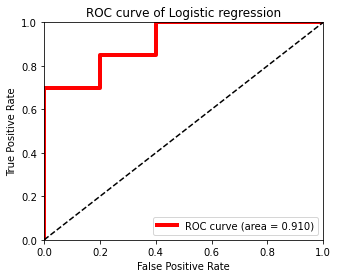

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")


In [24]:
# y가 0과 1을 각각 얼마나 가지고 있는지를 출력합니다.
df['y'].value_counts()


1    71
0    11
Name: y, dtype: int64

In [25]:
# 1:1 비율로 랜덤 샘플링을 수행합니다.
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist()
#negative_random_idx 는 정확도가 낮을수 있음.

In [26]:
# 랜덤 데이터로 데이터셋을 나눕니다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(70, 842)
(30, 842)


In [27]:
# 로지스틱 회귀모델을 다시 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 학습한 모델을 테스트 데이터로 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.83
Precision : 0.812
Recall : 0.867
F1 : 0.839


In [28]:
# Confusion matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[12  3]
 [ 2 13]]


AUC : 0.853


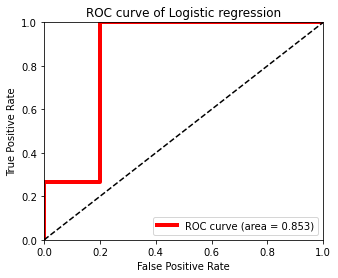

In [29]:
# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

<BarContainer object of 842 artists>

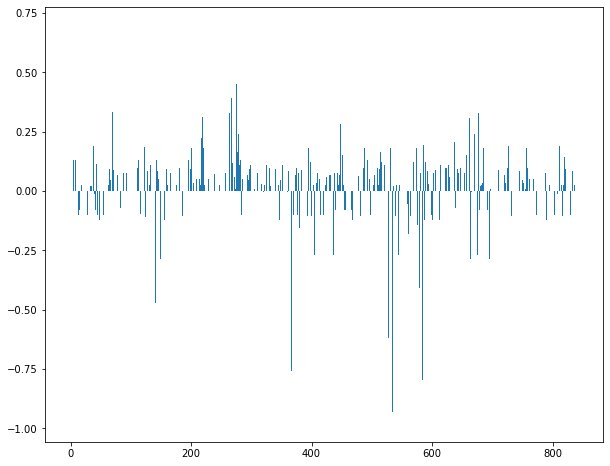

In [30]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [31]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.6921327618472729, 180), (0.461880959293318, 381), (0.44873014701240843, 275), (0.40640931529868707, 623), (0.38973418946892446, 267)]
[(-0.7593976565993956, 367), (-0.7743000796277633, 11), (-0.7954497407924157, 584), (-0.9325298350731617, 534), (-0.9728846854499148, 354)]


In [32]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)


In [33]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')


{267: '맛있게/Adjective', 623: '잘/Verb', 298: '먹었어요/Verb', 448: '식사/Noun', 687: '중/Suffix', 514: '에/Jos..


In [39]:
# 상위 50개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:50]:
    print(invert_index_vectorizer[coef[1]], coef[0])


도/Josa 0.6921327618472729
분위기/Noun 0.461880959293318
맛있어요/Adjective 0.44873014701240843
잘/Verb 0.40640931529868707
맛있게/Adjective 0.38973418946892446
곳/Noun 0.3312532740146822
맛/Noun 0.3289235857925356
좋았어요/Adjective 0.327332767329913
랑/Josa 0.31279629714064466
좀/Noun 0.30939808830388155
좋고/Adjective 0.3063433833706624
아주/Noun 0.2856579624896856
식사/Noun 0.28382793266860823
친절했음/Adjective 0.24078298111603186
맛있었음/Adjective 0.24078298111603186
깔끔했고/Adjective 0.24078298111603186
좋습니다/Adjective 0.23811151951769047
먹었어요/Verb 0.2331576708963969
또/Noun 0.22144739155246498
저희/Noun 0.2062324197028038
먹고/Verb 0.20503305632011742
이고/Josa 0.19488762936448453
정말/Noun 0.19150780499907383
할/Verb 0.1896775331823505
챙겨주셔서/Verb 0.1887663896647527
감사합니다/Verb 0.1887663896647527
재료/Noun 0.18745949675316886
대체로/Noun 0.18745949675316886
내용/Noun 0.18745949675316886
배불러요/Adjective 0.1870797395571307
주차/Noun 0.1812650077247145
으로/Josa 0.18065098973158442
채워지질/Verb 0.18027929990028357
예/Modifier 0.180279299900283

In [40]:
# 상위 50개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-50:]:
    print(invert_index_vectorizer[coef[1]], coef[0])


대로/Josa -0.10456981031020068
너무/Adverb -0.10779205841520681
해주신거/Verb -0.12173768995650075
플레이/Noun -0.12173768995650075
편이였으나/Verb -0.12173768995650075
팅/Noun -0.12173768995650075
중요한/Adjective -0.12173768995650075
있는거/Adjective -0.12173768995650075
인데/Josa -0.12173768995650075
이나/Josa -0.12173768995650075
아쉬움/Noun -0.12173768995650075
배려/Noun -0.12173768995650075
다양한/Adjective -0.12173768995650075
같아서/Adjective -0.12173768995650075
피자/Noun -0.14042331378876075
은/Josa -0.1427389620763007
분들/Suffix -0.15697063190711133
서비스/Noun -0.15903154949422746
파스타/Noun -0.16164705144787672
후식/Noun -0.1826981046053871
요리/Noun -0.1826981046053871
솥밥/Noun -0.1826981046053871
부실함/Adjective -0.1826981046053871
반찬/Noun -0.1826981046053871
류/Noun -0.1826981046053871
된장찌개/Noun -0.1826981046053871
나온/Verb -0.1826981046053871
제/Noun -0.1983202276567499
좋았는데/Adjective -0.26998310357144323
와/Josa -0.26998310357144323
스테이크/Noun -0.26998310357144323
살짝/Noun -0.26998310357144323
모두/Noun -0.26998310357144323
짠/Ve

In [36]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [37]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('분위기/Noun', 0.461880959293318),
 ('곳/Noun', 0.3312532740146822),
 ('맛/Noun', 0.3289235857925356),
 ('좀/Noun', 0.30939808830388155),
 ('아주/Noun', 0.2856579624896856),
 ('식사/Noun', 0.28382793266860823),
 ('또/Noun', 0.22144739155246498),
 ('저희/Noun', 0.2062324197028038),
 ('정말/Noun', 0.19150780499907383),
 ('재료/Noun', 0.18745949675316886)]

In [38]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('맛있어요/Adjective', 0.44873014701240843),
 ('맛있게/Adjective', 0.38973418946892446),
 ('좋았어요/Adjective', 0.327332767329913),
 ('좋고/Adjective', 0.3063433833706624),
 ('친절했음/Adjective', 0.24078298111603186),
 ('맛있었음/Adjective', 0.24078298111603186),
 ('깔끔했고/Adjective', 0.24078298111603186),
 ('좋습니다/Adjective', 0.23811151951769047),
 ('배불러요/Adjective', 0.1870797395571307),
 ('빠르게/Adjective', 0.18027929990028357)]